# Regresión para el CSV tips.csv

In [1]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## 1. Carga del dataset

In [112]:
df = pd.read_csv('./tips.csv')
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


Como se puede apreciar, se cuanta con las siguientes columnas:

- **total_bill**: Hace referencia al coste total de la cuenta.
- **tip**: Variable decimal.
- **sex**: Variable categorica (Male/Female).
- **smoke**: Variable booleana.
- **day**: Variable categorica (Sat/Sun/Thur/Fri).
- **time**: Variable categorica (Dinner/Lunch)
- **size**: Variable numerica.

También, con un primer análisis, con la función `df.isnull().values.any()` se puede ver que este data frame no tiene valores nulos.

In [113]:
## Se añaden dos columnas más para poder analizar si guarda relación con otras columnas 
df['day_num'] = df['day'].apply(lambda x: ["Mon", "Tue", "Wen", "Thur", "Fri", "Sat", "Sun"].index(x))
df['time_num'] = df['time'].apply(lambda x: ["Dinner", "Lunch"].index(x))
df

,total_bill,tip,sex,smoker,day,time,size,day_num,time_num
0,16.99,1.01,Female,No,Sun,Dinner,2,6,0
1,10.34,1.66,Male,No,Sun,Dinner,3,6,0
2,21.01,3.50,Male,No,Sun,Dinner,3,6,0
3,23.68,3.31,Male,No,Sun,Dinner,2,6,0
4,24.59,3.61,Female,No,Sun,Dinner,4,6,0
...,...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,5,0
240,27.18,2.00,Female,Yes,Sat,Dinner,2,5,0
241,22.67,2.00,Male,Yes,Sat,Dinner,2,5,0
242,17.82,1.75,Male,No,Sat,Dinner,2,5,0


## 2. Visualización

[Text(0.5, 1.0, 'Pedidos por día de la semana')]

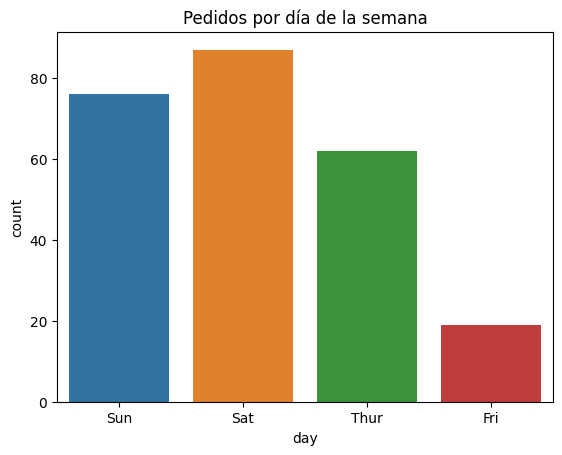

In [3]:
sns.countplot(data=df, x='day').set(title='Pedidos por día de la semana')

/home/martin/Projects/edix/tips/.env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


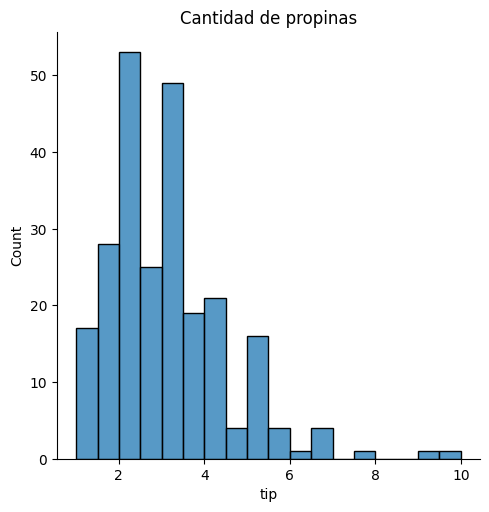

In [4]:
sns.displot(data=df, x='tip').set(title='Cantidad de propinas')
## Se puede apreciar que hay más pripinas de cantidades pequeñas

[Text(0.5, 1.0, 'Pedidos por turno')]

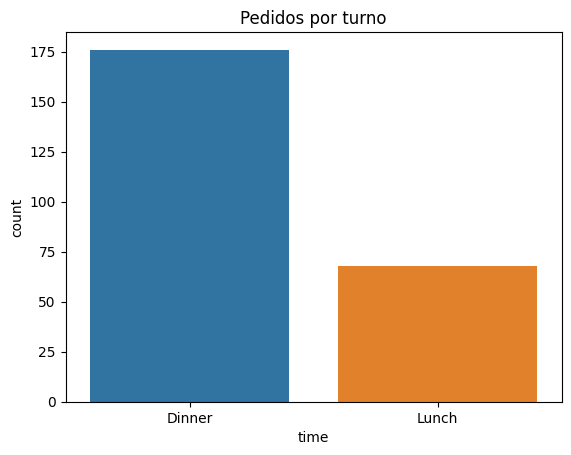

In [5]:
sns.countplot(data=df, x='time').set(title='Pedidos por turno')
## Se puede apreciar que hay más pedidos en el turno de noche

/home/martin/Projects/edix/tips/.env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


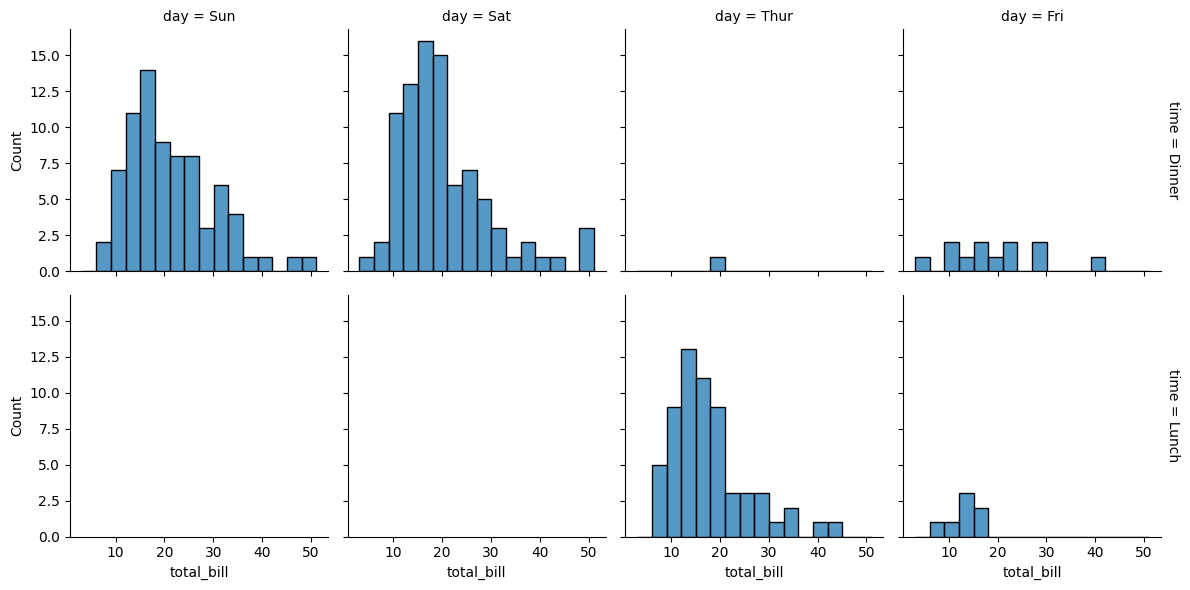

In [6]:
sns.displot(
    df, x="total_bill", col="day", row="time",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

/home/martin/Projects/edix/tips/.env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


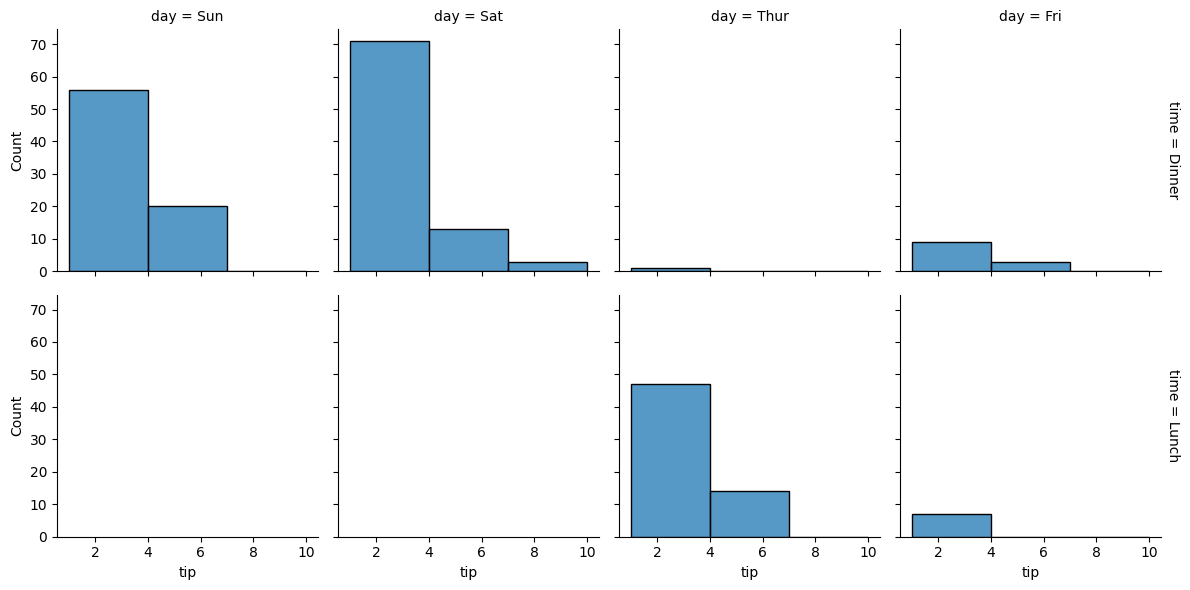

In [7]:
sns.displot(
    df, x="tip", col="day", row="time",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

/home/martin/Projects/edix/tips/.env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


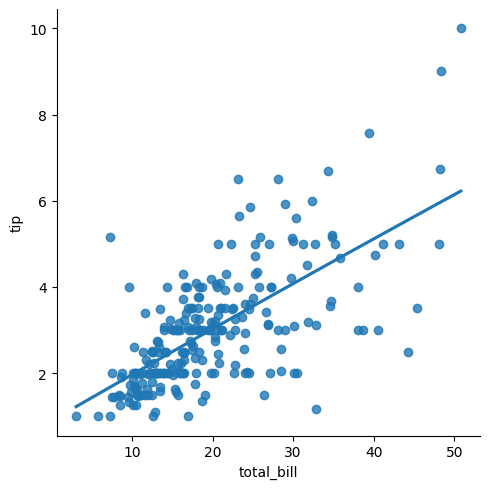

In [8]:
sns.lmplot(x ="total_bill", y ="tip", data = df, order = 2, ci = None)

<Axes: >

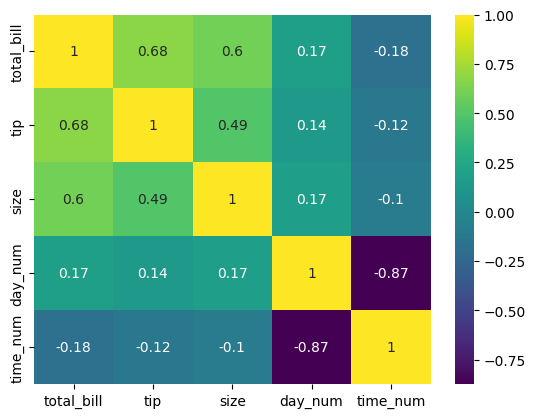

In [9]:
df_corr = df.corr(numeric_only=True)
sns.heatmap(df_corr, annot=True, cmap='viridis')

### Conclusiones

Como se puede apreciar, las propiedades que tienen una mayor relación son **tip** y **total_bill**, por lo que van a ser estas con las que realice la regresión

## 3. Regresión

SCORE:  0.5449381659234664
MAE: 0.6208580000398983
MSE: 0.5688142529229536
RMSE: 0.7541977545199625


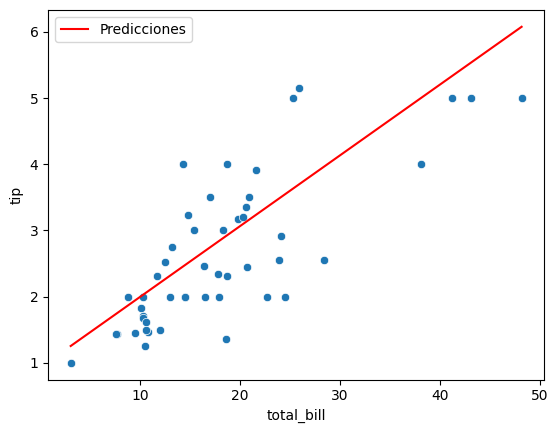

In [124]:
X = df[['total_bill']]
y = df['tip']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


sns.scatterplot(x=X_test['total_bill'], y=y_test) # test
sns.lineplot(x=X_test['total_bill'], y=y_pred, c='r', label='Predicciones') # predicciones


from sklearn.metrics import mean_absolute_error,mean_squared_error
 
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)
 

print("SCORE: ", model.score(X_test, y_test))
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)


### Ejemplo de predicción con datos propios:

In [117]:
custom_data = pd.DataFrame({'total_bill': [23.9, 50, 60, 80, 200]})
y_new = model.predict(custom_data)

custom_data['estimated_tip'] = y_new

custom_data

,total_bill,estimated_tip
0,23.9,3.481668
1,50.0,6.273421
2,60.0,7.343058
3,80.0,9.482332
4,200.0,22.317977
